# Loan Cancellation #

## Summary
I focused on building a parsimonious model by first reducing the number of variables to a workable representative set, and then understanding the effect of each variable on the probability of loan cancellation, and discarding variables with limited predictivity. My final model uses whether the loanee has taken out a Prosper loan before, the size of loan requested and the loan's interest rate, as well as loanee's monthly debt, monthly income, employment status, credit card use and number of real estate trades, and the number of loan inquiries initialized as predictors. My final model achieves an AUC score of xxx.

Insert Figure

## Methodology

### Dimensional Reduction

To handle the large number of columns in the data (86 to start), my initial focus was dimensional reduction: Finding a smaller set of variables that still encompasses most of the original information. One way to do this would be Principal Component Analysis (PCA) followed by rotation of eigenvectors, but since I was dealing with an unfamiliar data set, I preferred to use a different method to allow me to pare down data more deliberately. Instead, I used Pearson's r to find variables that were highly correlated, which I then turned into a graph with networkx to find connected families. After doing this, I chose one representive variable from each family and dropped the rest. 

My first application of this graph technique with r = .55 found twelve families and reduced the number of variables from 80 to 56. I chose an r such that the max family size would be no larger than 10. I then reapplied the same method with a lower cutoff of r = .45. This method proved to be imperfect - in the original run-through, I ended up discarding NumPriorProsperLoans, which I later realized to be highly important.

### Logistic Regression with Individual Variables

I then performed a logistic regression with each individual variable to see whether a significant relation exists, and then I started to build my final logistic model one variable at a time. In the case of clearly related families of variables, such as the combination of DolMonthlyDebt-DolMonthlyIncome-FracDebtToIncomeRatio, I investigated the set of variables as a group to see what combination of variables provided better predictivity (in this case, DolMonthlyDebt and DolMonthlyIncome performed best). Plugging in each variable at a time proved painstaking, but given my unfamiliarity with loan data I didn't feel comfortable with making assumptions about which variables might be significant.

In the end, I created the variable BoolPriorProsperLoanee, used the numerical variables DolLoanAmountRequested, PctBankcardUtil, DolMonthlyDebt, DolMonthlyIncome, BorrowerRate, NumRealEstateTrades, StrEmploymentStatus, NumTotalInquiries' and the categorical variable StrEmploymentStatus.

## Findings

* The single best predictor of loan cancellation is simply familiarity with the Prosper platform. Users who have taken out a Prosper loan before have only a 13% chance of cancellation, versus 36% if they have not.

* Potential loanees who list their employment status as "Other" are much more likely to cancel than ...

* One might expect the interest rate of the loan to strongly influence cancellations, but in fact interest rate has only a subtle influence on cancellation, subordinate to other factors.

In [1]:
from datetime import datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
import time
%matplotlib notebook

import networkx as nx
from networkx.algorithms.components.connected import connected_components

#show up to 100 columns.
pd.set_option('display.max_columns', 100)

Load in the data from the pickle file.

In [2]:
data_file = "new_theorem_data.p"

## data appears to have been savied in Python 2 - changing encoding allows us to properly load data
with open(data_file, 'rb') as pickle_file:
    data = pickle.load(pickle_file, encoding='latin1') 

Sample listing.

In [4]:
data.iloc[0]

ListingID                                                       973605
DateCreditPulled                                   2013-10-13 01:50:58
DateListingStart                            2014-01-26 19:00:08.887000
DateListingCreation                         2013-10-13 01:50:56.287000
EnumListingStatus                                                    7
DolLoanAmountRequested                                           15000
BoolPartialFundingApproved                                        True
CreditGrade                                                          B
LenderYield                                                      0.152
BorrowerRate                                                     0.162
NumMonthsTerm                                                       60
DolMonthlyLoanPayment                                           366.37
FICOScore                                                          689
ProsperScore                                                         6
EnumLi

In [15]:
print('Number of rows:',len(data))
cols = data.columns.values
print('Number of columns:',len(cols))

Number of rows: 252469
Number of columns: 86


Let's visualize how the different columns are inter-related by showing a heat map of Pearson's r between pairs of variables.

<IPython.core.display.Javascript object>


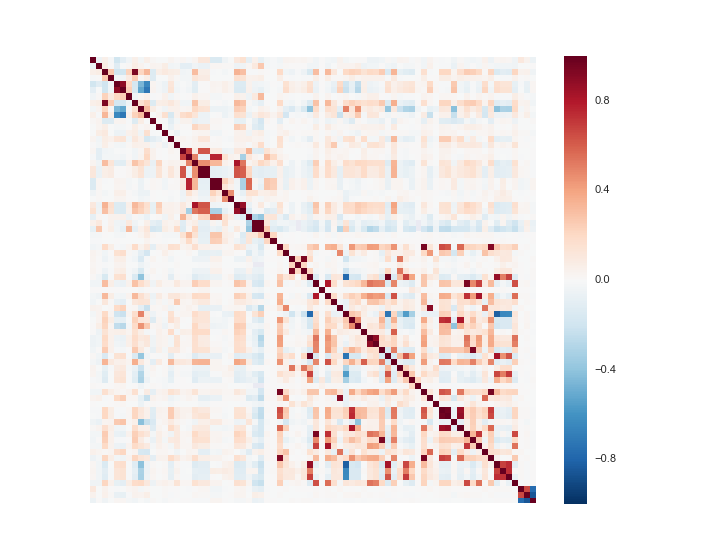

In [21]:
corr = data.corr()
corr.head()

## 86 different categories - start by taking correlation matrix to figure out which categories are redundant
f, ax = plt.subplots(figsize=(9,7))

# Draw the heatmap using seaborn
sns.heatmap(corr, square=True, cbar=True, xticklabels=False, yticklabels=False)

There are many visible families of variables encoding very similar information. Let's gather these sets of variables by turning them into a graph network. I've provided a solution using networkx below.

In [22]:
## thank you to stack overflow for the elegant solution: 
## http://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def to_graph(l):
    G = nx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

First, we create a list for each variable of other variables that are highly correlated with it (|r|>.55).

In [23]:
## cutoff of .6 recovers 47 inter-connected variables, .5 recovers 52, .55 recovers 50
## cutoff of .55 features largest group at length 10 - probably don't want to exceed that
tentative_families = []
cutoff = .55

for name, col in corr.iteritems():
    
    highly_correlated = (abs(col) > cutoff) & (col.index != name)
    high_corr_list = col[highly_correlated].index.tolist()
    
    if high_corr_list != []:
        tentative_families.append(sorted(high_corr_list + [ name ]))
        
tentative_families.sort()
tentative_families = list(tentative_families for tentative_families,_ in itertools.groupby(tentative_families))

for fam in sorted(tentative_families):
    print(fam)

['BoolEverWholeLoan', 'BoolIsFractionalLoan', 'EnumLoanFractionalType']
['BoolOwnsHome', 'DolMonthlyDebt', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BoolOwnsHome', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BoolOwnsHome', 'DolRealEstateBalance', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BorrowerRate', 'LenderYield', 'ProsperScore']
['DolLoanAmountRequested', 'DolMonthlyLoanPayment']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalBorrowed', 'DolPriorProsperLoansPrincipalOutstanding']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalOutstanding']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrinci

This can effectively be interpreted as lists of connected nodes. We translate the lists above into a graph network, and then return families of connected nodes.

In [13]:
G = to_graph(tentative_families)
cc = nx.connected_components(G)
families = []

for nodes in cc:
    families.append(list(nodes))
    
families = sorted([ sorted(fam) for fam in families ])
    
for fam in families:
    print(fam, len(fam))
    
ll = [ len(fam) for fam in families ]
print(sum(ll))

['BoolEverWholeLoan', 'BoolIsFractionalLoan', 'EnumLoanFractionalType'] 3
['BoolOwnsHome', 'DolMonthlyDebt', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalBalanceInstallTradesReptd6', 'DolTotalPaymentAllOpenTrades6'] 7
['BorrowerRate', 'LenderYield', 'ProsperScore'] 3
['DolLoanAmountRequested', 'DolMonthlyLoanPayment'] 2
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalBorrowed', 'DolPriorProsperLoansPrincipalOutstanding', 'NumPriorProsperLoans', 'NumPriorProsperLoansActive', 'NumPriorProsperLoansCyclesBilled', 'NumPriorProsperLoansEarliestPayOff', 'NumPriorProsperLoansOnTimePayments'] 10
['DolRevolvingBalance', 'DolTotalBalanceOpenRevolving6'] 2
['NumBankcardTradesOpened12', 'NumCreditLines84', 'NumCurrentCreditLines', 'NumOpenCreditLines', 'NumOpenRevolvingAccounts', 'NumSatisfactoryAccounts', 'NumTrades'] 7
['NumDelinquencies84', 'NumDelinquenciesOver30Days', 'NumD

I go through each family individually, give each one a name, and then choose a single variable to represent that family. Then, drop all of the variables in each family except for the chosen representative variable.

In [26]:
## give custom descriptive names to each family
# two items: first, each unit in the family; second, the variable(s) you're going to keep around.
family_dict = {}
family_dict['fractional_loan'] = [families[0],'BoolEverWholeLoan']
family_dict['debt'] = [families[1],'DolMonthlyDebt']
family_dict['borrower_rate'] = [families[2],'BorrowerRate']
family_dict['loan_amount'] = [families[3],'DolLoanAmountRequested']
family_dict['prosper_history'] = [families[4],'NumPriorProspectLoans']
family_dict['revolving_balance'] = [families[5],'DolTotalBalanceOpenRevolving6']
family_dict['credit'] = [families[6],'NumCurrentCreditLines']
family_dict['delinquencies'] = [families[7],'PctTradesNeverDelinquent']
family_dict['inquiries'] = [families[8],'NumTotalInquiries']
family_dict['prior_prosper_loans'] = [families[9],'NumPriorProsperLoans61dpd']
family_dict['real_estate'] = [families[10],'NumRealEstateTrades']
family_dict['current_delinquency'] = [families[11],'NumTradesCurr30DPDOrDerog6']

## create reduced data set by dropping headers...
reduced_data = pd.DataFrame.copy(data, deep = True)

## save this preliminary set of variables as a pickle file.

In [25]:

## immediately drop columns that are unlikely/unable to cause loan cancellation (ID numbers/dates)
drop_cols = ['ListingID', 'DateCreditPulled', 'DateListingStart', 'DateListingCreation', 'DateWholeLoanStart', 'DateWholeLoanEnd']
reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [ ]:
## drop similar columns as determined by families
for fam, items in family_dict.items():
    drop_cols = list(items[0])
    drop_cols.remove(items[1]) #keep our chosen representative variable for that family
    reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [ ]:
reduced_names = reduced_data.columns.values
print(len(reduced_names))

In [3]:
## manually drop a few other columns that won't help our analysis...
reduced_data.drop(['StrState','StrBorrowerCity','BoolIncomeVerifiable'], axis=1, inplace=True)

NameError: name 'reduced_data' is not defined